# Generation of full feature datacubes for the SK test sites via client-side block processing
In this notebook we generate the feature datacubes for the year 2021 which will be used to run the offline inference test to compare the results to the openEO inference run. Moreover, these datacubes will be used to validate the openEO SK training data pipeline results. <br><br>
Note: since all test sites are in the EU we use the developed openEO EU 20x20km processing grid which includes optimizes Sentinel-2 tile filters to reduce processing costs. Nevertheless, the approach also works globally by using the openEO global 20x20km processing grid.

In [1]:
import openeo
from openeo.extra.job_management import CsvJobDatabase
from eo_processing.utils import laea20km_id_to_extent, reproj_bbox_to_ll
from eo_processing.utils.helper import init_connection, location_visu
from eo_processing.utils.jobmanager import WeedJobManager
from eo_processing.utils.storage import get_gdrive_gdf, print_gdrive_overview, WEED_GDRIVE_Access
from eo_processing.openeo.processing import generate_master_feature_cube
from eo_processing.config import get_job_options, get_collection_options, get_standard_processing_options
import eo_processing.resources
import importlib.resources as importlib_resources
import geopandas as gpd
import pandas as pd
import os
from typing import Optional
import platform

### get the SK test sites from the GDrive

In [2]:
# init the GDRIVE access
gdrive = WEED_GDRIVE_Access(username='buchhornm', entry_point="1k27bitdRp41AtHq1xupyqwKaTLzrMUMu")

Please enter your password for the Terrascope VAULT:  ········


In [3]:
# get an overview of the folder structure
print_gdrive_overview(gdrive)

Found directory: 1k27bitdRp41AtHq1xupyqwKaTLzrMUMu
	SK_test-sites_alpha1_EPSG4326.gpkg
	European_terrestrial_LAEA20km_grid.gpkg
	global_terrestrial_UTM20k_grid.gpkg
	SK_v5_reference-points_EUNIS2012.csv
	global_terrestrial_UTM100k_grid.gpkg


In [4]:
# load the SK test sides into a GeoPandas GeoDataFrame
path_global_grid = gdrive.root + "/" + 'SK_test-sites_alpha1_EPSG4326.gpkg'
# use helper function to load the GDrive file directly
gdf_sites = get_gdrive_gdf(gdrive, path_global_grid)

### specify space context for the openEO run
The space context is set by intersecting the SK test sites (AOIs) with the openEO EU 20x20km tiling grid. Since the tiling grid has a smaller file size, it was also stored in the resources of the eo_processing package as well as on the GDrive folder. <br>

In [5]:
# get the LAEA-20km grid saved as EPSG:4326 vector
grid = importlib_resources.files(eo_processing.resources).joinpath('LAEA-20km.gpkg')
gdf_grid = gpd.read_file(os.path.normpath(grid))

In [6]:
# spatial intersect and retrieve the tile_ID's of the LAEA-20km grid (convert AOI to EPSG:4326 if needed)
gdf_aoi = gdf_grid[gdf_grid.intersects(gdf_sites.union_all())]

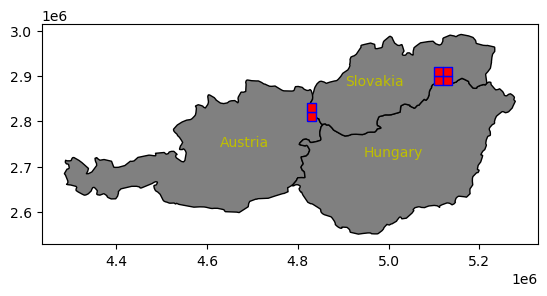

In [7]:
# visualization of the selected- tiles in the tiling grid which needs to be processed to cover the AOI
location_visu(gdf_aoi, zoom=True, region='EU', label=True)

### integrating the MultiBackendJobManager


#### creating the jobs dataframe
The `MultiBackendJobManager` uses a jobs database to set-up, start and monitor all desired jobs. We are using Pandas/GeoPandas to create a DataFrame storing the job and all parameters which should adapted for each job.

In this example we can directly use the GeoDataFrame of the tiling grid since after the intersection with the AOI is contains only the remaining block extents to process.

In [25]:
def create_job_dataframe(gdf: gpd.GeoDataFrame, year: int, file_name_base: str, target_crs: Optional[int] = None) -> gpd.GeoDataFrame:

    columns = ['name', 'target_epsg', 'file_prefix', 'start_date', 'end_date', 'geometry']
    dtypes = {'name': 'string', 'target_epsg': 'UInt16', 'file_prefix': 'string', 'start_date': 'string', 'end_date': 'string', 'geometry': 'geometry'}

    job_df = gdf.copy()

    # the time context is given by start and end date
    job_df['start_date'] = f'{year}-01-01'
    job_df['end_date'] = f'{year+1}-01-01'  # the end is always exclusive

    # adding the output file name pre-fix
    job_df['file_prefix'] = job_df.apply(lambda row: f'{file_name_base}_feature-cube_year{year}_{row['name']}', axis=1)

    # set the target epsg
    if target_crs is None:
        job_df['target_epsg'] = 3035
    else:
        raise NotImplementedError('target_crs is not yet implemented')

    return job_df.astype(dtypes)

In [26]:
job_df = create_job_dataframe(gdf_aoi, 2021, 'SK_alpha-1')

In [27]:
# show the jobs_database before conversion into a JobDatabaseInterface
job_df.head()

,name,geometry,start_date,end_date,file_prefix,target_epsg
11432,E482N280,"MULTIPOLYGON (((16.708 48.109, 16.732 48.289, ...",2021-01-01,2022-01-01,SK_alpha-1_feature-cube_year2021_E482N280,3035
11433,E482N282,"MULTIPOLYGON (((16.732 48.289, 16.756 48.468, ...",2021-01-01,2022-01-01,SK_alpha-1_feature-cube_year2021_E482N282,3035
13656,E510N288,"MULTIPOLYGON (((20.585 48.529, 20.623 48.707, ...",2021-01-01,2022-01-01,SK_alpha-1_feature-cube_year2021_E510N288,3035
13657,E510N290,"MULTIPOLYGON (((20.623 48.707, 20.661 48.885, ...",2021-01-01,2022-01-01,SK_alpha-1_feature-cube_year2021_E510N290,3035
13829,E512N288,"MULTIPOLYGON (((20.853 48.503, 20.892 48.681, ...",2021-01-01,2022-01-01,SK_alpha-1_feature-cube_year2021_E512N288,3035


#### creating the job `start_job` function
The next step is to define a `start_job` function. This function will instruct the `MultiBackendJobManager` on how to initiate a new job on the selected backend. The `start_job` functionality should adhere to the following structure _start_job(row: pd.Series, connection: openeo.Connection, **kwargs)_.

In [34]:
def featurecube_generation(row: gpd.GeoSeries, connection: openeo.Connection, provider: str , **kwgs) -> openeo.BatchJob:
    """Start a new job using the specified row out of the jobs GeoDataFrame and connection."""

    # Get the variable parameters from the dataframe
    tileID = row["name"]
    start = row["start_date"]
    end = row["end_date"]
    file_name = row["file_prefix"]
    epsg = int(row["target_epsg"])

    # convert the row name into a openEO bbox dict giving the spatial extent of the job
    processing_extent = laea20km_id_to_extent(tileID)

    # define job_options, processing_options,  and collection_options
    job_options = get_job_options(provider=provider)
    collection_options = get_collection_options(provider=provider)
    processing_options = get_standard_processing_options(provider=provider, task='feature_generation')

    # adapt the epsg to the processing grid
    processing_options.update(target_crs = epsg)

    #create the progress graph for the feature cube
    # define the S1/S2 processed feature cube (Note: do not set spatial extent since we had it over in the end)
    data_cube = generate_master_feature_cube(connection,
                                             None,
                                             start,
                                             end,
                                             **collection_options,
                                             **processing_options)

    # now we merge in the NON ON-DEMAND processed features (DEM and WERN features)
    # load the DEM from a CDSE collection
    DEM = connection.load_collection(
        "COPERNICUS_30",
        bands=["DEM"]
        )
    # reduce the temporal domain since copernicus_30 collection is "special" and feature only are one time stamp
    DEM = DEM.reduce_dimension(dimension='t', reducer=lambda x: x.last(ignore_nodata=True))
    # resample the cube to 10m and EPSG of corresponding 20x20km grid tile
    DEM = DEM.resample_spatial(projection=processing_options['target_crs'], 
                               resolution=processing_options['resolution'],
                               method="bilinear")
    # merge in S1/S2 data
    data_cube = data_cube.merge_cubes(DEM)

    # load the WERN features from public STAC
    WENR = connection.load_stac("https://stac.openeo.vito.be/collections/wenr_features")
    # resample the cube to 10m and EPSG of corresponding 20x20km grid tile
    WENR = WENR.resample_spatial(projection=processing_options['target_crs'],
                                 resolution=processing_options['resolution'],
                                 method="near")
    # drop the time dimension (needed) so that features have only one time stamp
    WENR = WENR.drop_dimension('t')
    # merge in S1/S2 data
    data_cube = data_cube.merge_cubes(WENR)

    # filter spatial the whole cube
    data_cube = data_cube.filter_bbox(processing_extent)

    job = data_cube.create_job(title=file_name,
                               description=f'generation of full feature data cube for tile {tileID}',
                               out_format='GTiff',
                               job_options=job_options,
                               filename_prefix=file_name,
                               )
    return job

#### set the root output folder

In [29]:
# define the output folder (make sure you adapt this to your folder structure)
if platform.system() == 'Windows':
    out_root = os.path.normpath(r'\\netapp03.vgt.vito.be\habitat\slovakia\openEO_tests\alpha-1\3_datacubes_test-sides')
else:
    out_root = os.path.normpath(r'/data/habitat/slovakia/openEO_tests/alpha-1/3_datacubes_test-sides')
os.makedirs(out_root, exist_ok=True)

#### run the jobs
With our jobs database and job definition set up, we can now run the jobs using the `MultiBackendJobManager`. This involves defining a path to where we will store the job tracker which contains the job statuses and metadata.
<br> <br>
Note: If the specified job tracker path, points to an existing jobs database (either a .csv or .parquet file), that file will be used as the job tracker, and the input jobs database will be disregarded.

In [30]:
# generate a unique name for the job tracker database (here: CSV file)
job_tracker = os.path.normpath(os.path.join(out_root, 'job_tracker_feature-cube-generation.csv'))

In [31]:
# init of MultiBackendJobManager (A viz switch has been added to enable vizualization of status
manager = WeedJobManager(root_dir=out_root, poll_sleep=30, viz=True)

In [32]:
# create a connection to backend and add this active backend to the jobmanager
backend = 'cdse'  # also possible: cdse-stagging, terrascope, development, creodias, sentinelhub
connection = init_connection(backend)
manager.add_backend(backend, connection=connection, parallel_jobs=6)

Authenticated using refresh token.


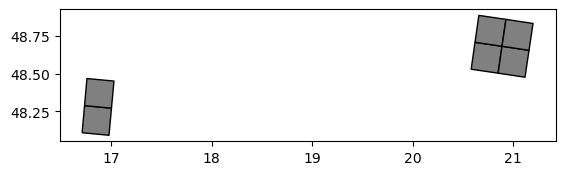

ValueError: No dimension named 't' (valid names: ['bands'])

In [35]:
# due to a bug in the JobManager class we first have to create the CSVJobDatabase by ourself and write it to disk so that we get all custom columns!
job_db = CsvJobDatabase(path=job_tracker)
if job_db.exists():
    print(f"Resuming `run_jobs` from existing {job_db}")
else:
    df = manager._normalize_df(job_df)
    job_db.persist(df)

manager.run_jobs(start_job=featurecube_generation, job_db=job_db)

### validate that all needed feature data cubes are generated

In [ ]:
# load the job_tracker file into a pandas DataFrame
df_tracker = pd.read_csv(job_tracker)

In [ ]:
# Check if all values in column "status" have the value "finished"
all_finished = df_tracker['status'].eq('finished').all()
if all_finished:
    print("All jobs are finished.")
else:
    print("Some jobs are not finished. Reset the non finished status rows to 'not_started' flag and restart the manager.run_jobs() line manually.")

In [31]:
# print the costs of the full job
print(f'The feature datacube generation {df_tracker.shape[0]} 20x20km tiles has cost overall {df_tracker.cost.sum()} credits ({df_tracker.cost.sum() * 0.01} EURO). ')

NameError: name 'df_tracker' is not defined

In [ ]:
# get the list of links to the GeoTif files
df_tracker['path_result'] = df_tracker['file_prefix'].apply(lambda x: os.path.normpath(os.path.join(out_root, f'{x}.tif')))
path_Results = df_tracker['path_result'].tolist()

In [ ]:
# Verify that all GeoTIFF files in path_Results exist
for file_path in path_Results:
    assert os.path.exists(file_path), f"File not found: {file_path}"